In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator # Modern simulator from qiskit-aer
from qiskit.visualization import plot_histogram, circuit_drawer # plot_state_city is less direct for probabilities
import matplotlib.pyplot as plt
import numpy as np
import math


#Configuration


In [3]:
NUM_QUBITS = 2
MARKED_ITEM_BINARY = "10" # Example: searching for the state |10>
TOTAL_ITEMS = 2**NUM_QUBITS
PLOT_STATE_EVOLUTION = True # Set to False to disable intermediate state plotting

#Validate Configuration

In [4]:
if len(MARKED_ITEM_BINARY) != NUM_QUBITS:
    raise ValueError(f"MARKED_ITEM_BINARY ('{MARKED_ITEM_BINARY}') must have length {NUM_QUBITS}")
if not all(c in '01' for c in MARKED_ITEM_BINARY):
    raise ValueError(f"MARKED_ITEM_BINARY ('{MARKED_ITEM_BINARY}') must contain only '0' or '1'")

print(f"--- Quantum Peek-a-Boo ---")
print(f"Goal: Find the marked item '{MARKED_ITEM_BINARY}' among {TOTAL_ITEMS} items.")
print(f"Quantum system will use {NUM_QUBITS} qubits.")
print(f"Plotting state evolution: {PLOT_STATE_EVOLUTION}")
print("-" * 40)

--- Quantum Peek-a-Boo ---
Goal: Find the marked item '10' among 4 items.
Quantum system will use 2 qubits.
Plotting state evolution: True
----------------------------------------


# Classical search Implementation

In [5]:
def classical_search(num_total_items, marked_item_str_binary):
    print("\n--- Classical Search ---")
    marked_idx_decimal = int(marked_item_str_binary, 2)
    checks = 0
    found = False
    print(f"Searching for item at decimal index: {marked_idx_decimal} (binary: {marked_item_str_binary})")
    for i in range(num_total_items):
        checks += 1
        current_item_binary = format(i, f'0{NUM_QUBITS}b')
        if i == marked_idx_decimal:
            print(f"Classical: Toy FOUND in box '{current_item_binary}' (decimal {i}) after {checks} check(s).")
            found = True
            break
    if not found:
        print("Classical: Toy not found. This indicates an issue.")
    print(f"Classical Complexity: O(N). For {num_total_items} items, worst case is {num_total_items} checks.")
    return checks

classical_num_checks = classical_search(TOTAL_ITEMS, MARKED_ITEM_BINARY)
print("-" * 40)


--- Classical Search ---
Searching for item at decimal index: 2 (binary: 10)
Classical: Toy FOUND in box '10' (decimal 2) after 3 check(s).
Classical Complexity: O(N). For 4 items, worst case is 4 checks.
----------------------------------------


In [6]:
# Helper Function to plot probabilitis from Statevector
def plot_probabilities_from_statevector(statevector, title_suffix=""):
    """Calculates probabilities from statevector and plots them as a bar chart."""
    if not PLOT_STATE_EVOLUTION:
        return

    num_states = len(statevector)
    # Qiskit statevector is typically ordered |0...00>, |0...01>, ..., |1...11>
    # So, labels should be 0 to 2^N - 1 in binary form.
    labels = [format(i, f'0{NUM_QUBITS}b') for i in range(num_states)]

    probabilities = np.abs(statevector)**2 # Probabilities are squared magnitudes of amplitudes

    fig, ax = plt.subplots(figsize=(max(6, num_states * 0.8), 5)) # Adjust width based on num_states
    bars = ax.bar(labels, probabilities, color='deepskyblue', edgecolor='black')
    ax.set_xlabel("Computational Basis State")
    ax.set_ylabel("Probability")
    ax.set_title(f"State Probabilities {title_suffix}")
    ax.set_ylim(0, 1.05)
    ax.tick_params(axis='x', rotation=45 if num_states > 4 else 0) # Rotate labels if many states

    # Add probability values on top of bars
    for bar_idx, bar in enumerate(bars):
        yval = bar.get_height()
        # Highlight the marked item's bar
        if labels[bar_idx] == MARKED_ITEM_BINARY:
            bar.set_color('salmon')
            bar.set_edgecolor('darkred')
        ax.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f'{yval:.3f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    filename_suffix = title_suffix.lower().replace(' ', '_').replace('(', '').replace(')', '').replace(':', '')
    filename = f"state_probs_{filename_suffix}.png"
    plt.savefig(filename)
    print(f"  State probability plot saved to {filename}")
    # plt.show() # Uncomment to display plots immediately if not in a script/Colab

# Quantum Search (Grover's Algorithms)




--- Quantum Search (Grover's Algorithm) ---
Step 1: Initializing qubits to equal superposition using Hadamard gates.

  Simulating initial state (after Superposition)...


C:\Users\jayak\AppData\Local\Temp\ipykernel_4696\4270146932.py:7: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  num_states = len(statevector)


  State probability plot saved to state_probs_after_initial_superposition.png

Step 2: Performing 1 Grover iteration(s).

  --- Iteration 1 ---

  Simulating state after Iteration 1...
  State probability plot saved to state_probs_after_iteration_1.png

Step 3: Measuring all qubits (for final histogram).


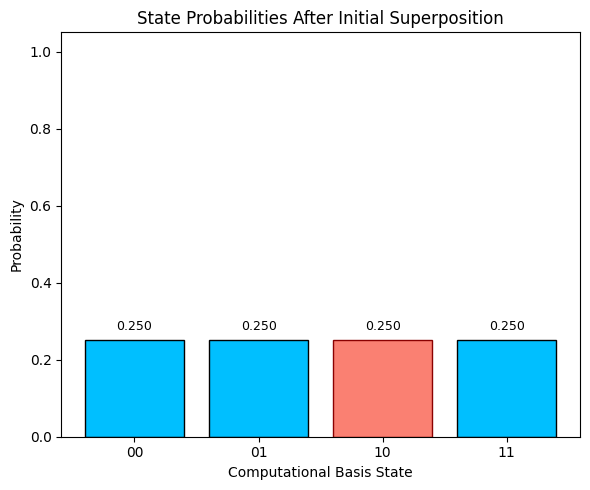

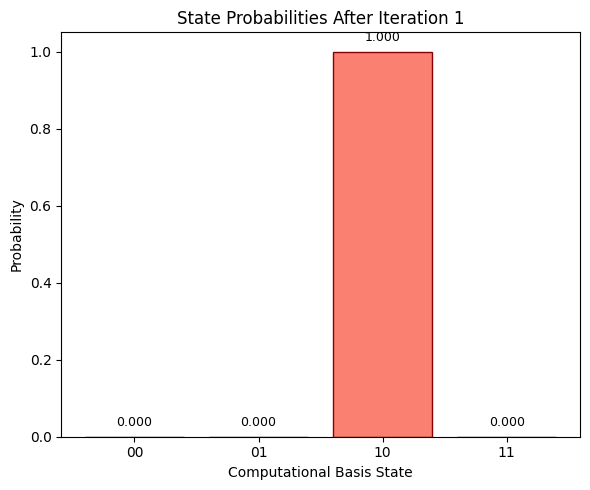

In [7]:
print("\n--- Quantum Search (Grover's Algorithm) ---")

qr = QuantumRegister(NUM_QUBITS, 'q')
# Circuit for statevector evolution (no classical register initially)
grover_circuit_sv = QuantumCircuit(qr)

# === Step 1: Initialization - Create Superposition ===
print("Step 1: Initializing qubits to equal superposition using Hadamard gates.")
grover_circuit_sv.h(qr)

# --- Simulate and plot initial state (after H gates) ---
if PLOT_STATE_EVOLUTION:
    print("\n  Simulating initial state (after Superposition)...")
    statevector_sim = AerSimulator(method='statevector') # Use AerSimulator for statevector
    temp_circuit_initial = grover_circuit_sv.copy()
    temp_circuit_initial.save_statevector() # Instruction to save the statevector

    # Transpile for the specific simulator
    transpiled_initial_circuit = transpile(temp_circuit_initial, statevector_sim)
    result_initial = statevector_sim.run(transpiled_initial_circuit).result()
    initial_statevector = result_initial.get_statevector(temp_circuit_initial) # Use original circuit for get_statevector
    plot_probabilities_from_statevector(initial_statevector, title_suffix="After Initial Superposition")

grover_circuit_sv.barrier()

# === Step 2: Grover Iterations (Oracle + Diffuser) ===
num_grover_iterations = math.floor( (math.pi / 4) * math.sqrt(TOTAL_ITEMS) )
if num_grover_iterations == 0: num_grover_iterations = 1
print(f"\nStep 2: Performing {num_grover_iterations} Grover iteration(s).")

for iteration in range(num_grover_iterations):
    print(f"\n  --- Iteration {iteration + 1} ---")
    # --- Oracle Construction ---
    # (Verbose printing of oracle steps removed for brevity, logic remains the same)
    for qubit_index in range(NUM_QUBITS):
        if MARKED_ITEM_BINARY[NUM_QUBITS - 1 - qubit_index] == '0':
            grover_circuit_sv.x(qr[qubit_index])
    if NUM_QUBITS == 1: grover_circuit_sv.z(qr[0])
    elif NUM_QUBITS == 2: grover_circuit_sv.cz(qr[0], qr[1])
    else: grover_circuit_sv.mcz(qr[:-1], qr[-1])
    for qubit_index in range(NUM_QUBITS):
        if MARKED_ITEM_BINARY[NUM_QUBITS - 1 - qubit_index] == '0':
            grover_circuit_sv.x(qr[qubit_index])
    grover_circuit_sv.barrier(label=f"Oracle_{iteration+1}")

    # --- Diffuser (Amplitude Amplification) Construction ---
    grover_circuit_sv.h(qr)
    grover_circuit_sv.x(qr)
    if NUM_QUBITS == 1: grover_circuit_sv.z(qr[0])
    elif NUM_QUBITS == 2: grover_circuit_sv.cz(qr[0], qr[1])
    else: grover_circuit_sv.mcz(qr[:-1], qr[-1])
    grover_circuit_sv.x(qr)
    grover_circuit_sv.h(qr)
    grover_circuit_sv.barrier(label=f"Diffuser_{iteration+1}")

    # --- Simulate and plot state after this iteration ---
    if PLOT_STATE_EVOLUTION:
        print(f"\n  Simulating state after Iteration {iteration + 1}...")
        temp_circuit_iter = grover_circuit_sv.copy()
        temp_circuit_iter.save_statevector()

        transpiled_iter_circuit = transpile(temp_circuit_iter, statevector_sim)
        result_iter = statevector_sim.run(transpiled_iter_circuit).result()
        iter_statevector = result_iter.get_statevector(temp_circuit_iter)
        plot_probabilities_from_statevector(iter_statevector, title_suffix=f"After Iteration {iteration + 1}")

# === Step 3: Measurement (Simulate with QASM for final histogram) ===
# Create a new circuit for measurement by copying the statevector circuit
# and adding classical register and measurement.
cr = ClassicalRegister(NUM_QUBITS, 'c')
measurement_circuit = grover_circuit_sv.copy(name="Grover_Measurement_Circuit")
measurement_circuit.add_register(cr)
measurement_circuit.measure(qr, cr)

print("\nStep 3: Measuring all qubits (for final histogram).")

In [8]:
# Print and visualize Quantum Circuit
print("\n--- Quantum Circuit Diagram (Full, with Measurement) ---")
try:
    # For nicer plots if pylatexenc is installed
    print(measurement_circuit.draw(output='text', fold=-1))
    circuit_fig = measurement_circuit.draw(output='mpl', style={'figwidth': 15, 'fold': 25})
    circuit_fig.savefig("quantum_peek_a_boo_circuit_full.png")
    print("\nFull quantum circuit diagram saved to quantum_peek_a_boo_circuit_full.png")
except ImportError:
    print("Install pylatexenc for better circuit diagrams: pip install pylatexenc")
    print(measurement_circuit.draw(output='text', fold=-1))
except Exception as e:
    print(f"Could not draw circuit with mpl: {e}")
    print(measurement_circuit.draw(output='text', fold=-1))


--- Quantum Circuit Diagram (Full, with Measurement) ---
     ┌───┐ ░ ┌───┐   ┌───┐ Oracle_1 ┌───┐┌───┐   ┌───┐┌───┐ Diffuser_1 ┌─┐   
q_0: ┤ H ├─░─┤ X ├─■─┤ X ├────░─────┤ H ├┤ X ├─■─┤ X ├┤ H ├─────░──────┤M├───
     ├───┤ ░ └───┘ │ └───┘    ░     ├───┤├───┤ │ ├───┤├───┤     ░      └╥┘┌─┐
q_1: ┤ H ├─░───────■──────────░─────┤ H ├┤ X ├─■─┤ X ├┤ H ├─────░───────╫─┤M├
     └───┘ ░                  ░     └───┘└───┘   └───┘└───┘     ░       ║ └╥┘
c: 2/═══════════════════════════════════════════════════════════════════╩══╩═
                                                                        0  1 

Full quantum circuit diagram saved to quantum_peek_a_boo_circuit_full.png



--- Simulating Final Measurement with QASM Simulator ---

Measurement Results from 2048 shots:
{'10': 2048}

Final measurement histogram saved to quantum_peek_a_boo_results_final.png


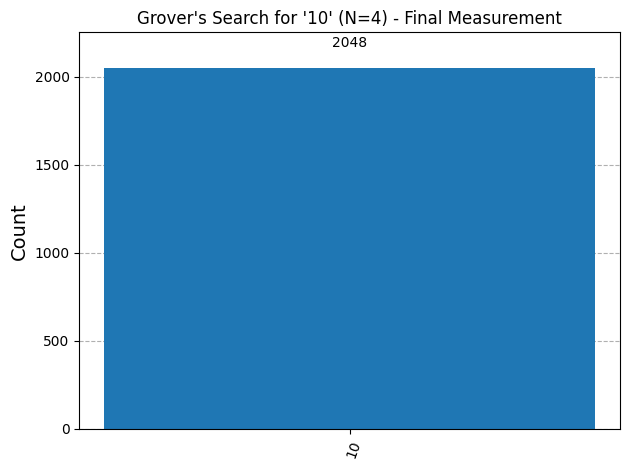

In [10]:
# Simulate with QASM Simulator for Measurement Counts
print("\n--- Simulating Final Measurement with QASM Simulator ---")
qasm_simulator = AerSimulator() # Default method is 'automatic', often chooses qasm
compiled_measurement_circuit = transpile(measurement_circuit, qasm_simulator)
num_shots = 2048
job = qasm_simulator.run(compiled_measurement_circuit, shots=num_shots)
result = job.result()
counts = result.get_counts(compiled_measurement_circuit)

print(f"\nMeasurement Results from {num_shots} shots:")
print(counts)

# --- Plot Histogram of Final Results ---
fig_hist, ax_hist = plt.subplots()
plot_histogram(counts, ax=ax_hist, title=f"Grover's Search for '{MARKED_ITEM_BINARY}' (N={TOTAL_ITEMS}) - Final Measurement")
fig_hist.tight_layout()
plt.savefig("quantum_peek_a_boo_results_final.png")
print("\nFinal measurement histogram saved to quantum_peek_a_boo_results_final.png")

# Final Conclusion and Comparision

In [11]:
print("\n--- Conclusion & Comparison ---")
print(f"Classical Search: Required {classical_num_checks} check(s) to find '{MARKED_ITEM_BINARY}'.")
print(f"Quantum Search (Grover's): Used {num_grover_iterations} 'quantum query/queries' (Oracle + Diffuser steps).")

most_probable_quantum_outcome = ""
if counts: # Check if counts dictionary is not empty
    most_probable_quantum_outcome = max(counts, key=counts.get)
    probability_of_marked_item = (counts.get(MARKED_ITEM_BINARY, 0) / num_shots) * 100
    print(f"  After final measurement simulation, the most probable state was '{most_probable_quantum_outcome}'.")
    print(f"  The target marked item '{MARKED_ITEM_BINARY}' was measured with a probability of {probability_of_marked_item:.2f}%.")

    if most_probable_quantum_outcome == MARKED_ITEM_BINARY:
        print(f"  Success! The quantum algorithm found the marked item '{MARKED_ITEM_BINARY}' with high probability.")
    else:
        print(f"  Note: The most probable outcome '{most_probable_quantum_outcome}' was not the marked item '{MARKED_ITEM_BINARY}'.")
        print("    This can happen due to: ")
        print("      - Not enough Grover iterations (especially if N is not a power of 4 for simple sqrt(N) iterations).")
        print("      - Probabilistic nature of quantum measurement (even with high probability, other outcomes are possible).")
        print("      - For N=4, 1 iteration is generally optimal and gives high success.")
else:
    print("  No measurement counts obtained from simulation.")


print("\nWhy is Quantum Better Here (Theoretically)?")
print(f"1. Parallelism via Superposition: Quantum computer initializes to explore all {TOTAL_ITEMS} items simultaneously.")
if PLOT_STATE_EVOLUTION: print(f"   (Visualized by the 'After Initial Superposition' plot showing equal probabilities).")
print(f"2. Quantum Query (Oracle): 'Marks' the target item by changing its phase.")
print(f"3. Amplitude Amplification (Diffuser): Systematically increases the probability of measuring the marked item.")
if PLOT_STATE_EVOLUTION: print(f"   (Visualized by the 'After Iteration X' plots showing the marked state's probability growing).")

print(f"\nScaling Advantage:")
print(f"  - Classical Search Complexity: O(N) queries/checks. For {TOTAL_ITEMS} items, up to {TOTAL_ITEMS} checks.")
print(f"  - Quantum Search (Grover's) Complexity: O(sqrt(N)) quantum queries. For {TOTAL_ITEMS} items, ~{num_grover_iterations} Grover iteration(s).")
print(f"\nFor large N (e.g., millions of items):")
print(f"  - Classical: Millions of checks.")
print(f"  - Quantum: Thousands of quantum queries (sqrt(Millions)).")
print("This difference in how the number of operations scales with the problem size (N) is the fundamental quantum advantage for search problems.")
print("While for N=4, classical is fast, the *principle of scaling* is what this project demonstrates.")


--- Conclusion & Comparison ---
Classical Search: Required 3 check(s) to find '10'.
Quantum Search (Grover's): Used 1 'quantum query/queries' (Oracle + Diffuser steps).
  After final measurement simulation, the most probable state was '10'.
  The target marked item '10' was measured with a probability of 100.00%.
  Success! The quantum algorithm found the marked item '10' with high probability.

Why is Quantum Better Here (Theoretically)?
1. Parallelism via Superposition: Quantum computer initializes to explore all 4 items simultaneously.
   (Visualized by the 'After Initial Superposition' plot showing equal probabilities).
2. Quantum Query (Oracle): 'Marks' the target item by changing its phase.
3. Amplitude Amplification (Diffuser): Systematically increases the probability of measuring the marked item.
   (Visualized by the 'After Iteration X' plots showing the marked state's probability growing).

Scaling Advantage:
  - Classical Search Complexity: O(N) queries/checks. For 4 items,